In [14]:
import numpy as np
import math
import sympy as sym
from sympy.functions.elementary.trigonometric import atan2
from scipy.integrate import ode
from sympy.utilities.lambdify import lambdify
from IPython.core.debugger import Tracer
import Kep_2_Cart
import Cart_2_Kep
import filter_functions
import warnings
import pickle
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

#MSIS: https://github.com/DeepHorizons/Python-NRLMSISE-00
#import time
from nrlmsise_00_header import *
from nrlmsise_00 import *
#SUBROUTINE GTD7D -- d[5] is the "effective total mass density
#for drag" and is the sum of the mass densities of all species
#in this model, INCLUDING anomalous oxygen.

%matplotlib inline
plt.rcParams['figure.figsize'] = (14.0, 8.0)
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
np.set_printoptions(precision=15)
sym.init_printing()
from IPython.display import display


In [15]:


#define constants
r_earth_const = 6378136.3 #meters
omega_const = 7.2921158553e-5
J_2_const = .00108262617385222
J_3_const = -.00000253241051856772
mu_earth = 3.986004415e14 #m^3/s^2


#Drag:
A_const = 0.9551567 #meters^2; cross-sectional area of satellite
m_const = 10 #kg; mass of satellite
C_D_est = 2.0
theta_dot_const = 7.2921158553e-5 #rad/sec


In [16]:

time_span = 86400 #seconds

# read python dict containing measurements
ensemble_file = open('Data Files/ensemble_density_grids.pkl', 'rb')
mydict2 = pickle.load(ensemble_file)
ensemble_file.close()

#shape: ensembles (# of combos) by lat by lon
ensembles_of_density_grid = mydict2['ensemble_of_density_grids'] 
print('Shape of Vector of Ensembles:', np.shape(ensembles_of_density_grid))
(num_of_ensembles, num_of_lat, num_of_lon) = np.shape(ensembles_of_density_grid)

latitude_grid = mydict2['latitudes'] 
longitude_grid = mydict2['longitudes'] 
lat_res = latitude_grid[1] - latitude_grid[0] #spacing between each latitude "tick"
lon_res = longitude_grid[1] - longitude_grid[0] #spacing between each longitude "tick"


#Date of Simulation Details:
#June 24th, 2017 at 6am (this is the date & time at the beginning of the simulation/orbit)
year = 2017
month = 6
day = 24
hour_init = 6
boulder_UT_offset = 6 #Boulder time + 6 hours = UT time
hour_init_UT = hour_init + boulder_UT_offset


# define position and velocity vectors (meters & meters/sec)
#satellite
a = r_earth_const + 400*1e3 # meters
e = 0#.05
i = math.radians(40)#40
cap_omega = 0
w = 0
nu = 0
(r_eci, v_eci) = Kep_2_Cart.COE2RV(a, e, i, cap_omega, w, nu, mu_earth)
print('\nInitial Position (ECI):', np.array(r_eci)/1e3, 'km')
print('Initial Velocity (ECI):', np.array(v_eci)/1e3, 'km')
print('Initial Orbit ALtitude:', (np.linalg.norm(r_eci)- r_earth_const)/1e3, 'km')

period = 2*math.pi*math.sqrt(a**3/mu_earth)
print('Period of Orbit:', period/(60), 'minutes')



#Canbera Station (DSS 34)
lat_dss34 = math.radians(-35.398333)
lon_dss34 = math.radians(148.981944)
alt_dss34 = 691.75 #m

r_ecef_dss34 = filter_functions.topo2ecef(lat_dss34, lon_dss34, alt_dss34, r_earth_const)
#print(r_ecef_dss34)

#Madrid Station (DSS 65) -- correct position of Madrid Station
lat_dss65 = math.radians(40.427222)
lon_dss65 = math.radians(355.749444)
alt_dss65 = 834.539 #m

r_ecef_dss65 = filter_functions.topo2ecef(lat_dss65, lon_dss65, alt_dss65, r_earth_const)
#print(r_ecef_dss65)

#Goldstone Station (DSS 13) 
lat_dss13 = math.radians(35.247164)
lon_dss13 = math.radians(243.205)
alt_dss13 = 1071.14904 #m

r_ecef_dss13 = filter_functions.topo2ecef(lat_dss13, lon_dss13, alt_dss13, r_earth_const)
#print(r_ecef_dss13)

Shape of Vector of Ensembles: (450, 37, 73)

Initial Position (ECI): [ 6778.136300000000119     0.                    0.               ] km
Initial Velocity (ECI): [ 0.                 5.874456678131549  4.929254431987093] km
Initial Orbit ALtitude: 400.0 km
Period of Orbit: 92.560390217187 minutes


In [17]:
#Propogate trajectory
def orbitpropogator_noSTM(t, X_vector, density):
    state = X_vector[0:3] 
    state_v = X_vector[3:6]
    

    #find X acceleration via the F(X) lambdified equation
    x_acc = x_sol_fcn(*state, *state_v, density)
    y_acc = y_sol_fcn(*state, *state_v, density)
    z_acc = z_sol_fcn(*state, *state_v, density)
    X_acc = np.array([x_acc, y_acc, z_acc])

    dx = np.array([state_v, X_acc])
    dx = dx.flatten()
    return dx


#t_UT : current universal time
#current longitude of space object
def calc_LST(t_UT, longitude):

    t_UT = t_UT%24
    
    #calculate change in longitude from UT and convert to change in hours/time
    #note: negative lon/lon above 180 is a negative difference in time & opposite for less than 180
    delta_lon = 360 - np.degrees(longitude)
    delta_lst = (delta_lon/360) * 24 #24 hours, unit = hours
    
    t_lst = t_UT - delta_lst 
    if t_lst < 0:
        t_lst = t_lst + 24

    #return now if want in hours
    
    #convert to degrees
    t_lst = (t_lst/24) * np.radians(360) #radians
    
    return t_lst

In [18]:
# **Setup Dynamical Model/Equations (Position & Velocity Forecast Model)

#Force equations: two body, J_2, & J_3
x, y, z, J_2, J_3, r_earth, mu, r,  x_dot, y_dot, z_dot, density = \
    sym.symbols('x y z J_2 J_3 r_earth mu r,  x_dot, y_dot, z_dot, density')
    
U_string = 'mu/r * ( 1 - J_2*(r_earth/r)**2 * (3/2 * (z/r)**2 - 1/2) )'
            #( 1 - J_2*(r_earth/r)**2 * (3/2 * (z/r)**2 - 1/2) ' #J_2 portion 
            #'- J_3 * (r_earth/r)**3 * ( 5/2 * (z/r)**3 - 3/2*(z/r) ) )') #J_3 portion 
U = sym.sympify(U_string)
U = U.subs(r, sym.sqrt(x**2+y**2+z**2))

U_diffeq_x = U.diff(x)
U_diffeq_y = U.diff(y)
U_diffeq_z = U.diff(z)


x_acc = U_diffeq_x.subs([(r_earth, r_earth_const), (mu, mu_earth), \
                              (J_2, J_2_const)])
y_acc = U_diffeq_y.subs([(r_earth, r_earth_const), (mu, mu_earth), \
                              (J_2, J_2_const)])
z_acc = U_diffeq_z.subs([(r_earth, r_earth_const), (mu, mu_earth), \
                              (J_2, J_2_const)])



#Add drag to J_2 force equations
C_D, A, m, density, theta_dot, val, val_dot = \
    sym.symbols('C_D A m density theta_dot val, val_dot')

drag_str = ('-(1/2)*C_D*(A/m)*density*'
                'sqrt((x_dot+theta_dot*y)**2 + (y_dot-theta_dot*x)**2 +'
                'z_dot**2)*(val_dot+theta_dot*val)')
drag_symp = sym.sympify(drag_str)

drag_symp = drag_symp.subs([(A, A_const), (m, m_const), (C_D, C_D_est),\
                        (theta_dot, theta_dot_const)])


x_drag_symp = drag_symp.subs([(r, sym.sqrt(x**2+y**2+z**2)), (val, y), (val_dot, x_dot)])
x_acc = x_acc + x_drag_symp

y_drag_symp = drag_symp.subs([(r, sym.sqrt(x**2+y**2+z**2)), (val, x), (val_dot, y_dot)])
y_acc = y_acc + y_drag_symp

z_drag_symp = drag_symp.subs([(r, sym.sqrt(x**2+y**2+z**2)), (val, z), (val_dot, z_dot)])
z_acc = z_acc + z_drag_symp


#print(z_acc)
    
x_sol_fcn = lambdify((x, y, z, x_dot, y_dot, z_dot, density), x_acc)
y_sol_fcn = lambdify((x, y, z, x_dot, y_dot, z_dot, density), y_acc)
z_sol_fcn = lambdify((x, y, z, x_dot, y_dot, z_dot, density), z_acc)


In [19]:
#generate measurements


x_s, y_s, z_s, x_sf, y_sf, z_sf, theta, theta_dot, t, x_dot, y_dot, z_dot = \
    sym.symbols('x_s, y_s, z_s, x_sf, y_sf, z_sf, theta, theta_dot, t, x_dot, y_dot, z_dot')

#define symbolic rho equation
rho = ('sqrt((x - x_s)**2 + (y - y_s)**2 + (z - z_s)**2)')
rho = sym.sympify(rho)
#sub rotation equation of ecef for eci
rho = rho.subs(x_s, x_sf*sym.cos(omega_const*t) - y_sf*sym.sin(omega_const*t))
rho = rho.subs(y_s, x_sf*sym.sin(omega_const*t) + y_sf*sym.cos(omega_const*t))
rho = rho.subs(z_s, z_sf)

#define symbolic rho dot equation
rho_dot = ('(x*x_dot + y*y_dot + z*z_dot - (x_dot*x_s+y_dot*y_s)*cos(theta) + \
           theta_dot*(x*x_s + y*y_s)*sin(theta) + (x_dot*y_s - y_dot*x_s)*sin(theta) +\
           theta_dot*(x*y_s - y*x_s)*cos(theta) - z_dot*z_s)/ rho')
rho_dot = sym.sympify(rho_dot)
#execute substitutions for rho_dot
rho_dot = rho_dot.subs(x_s, x_sf) 
rho_dot = rho_dot.subs(y_s, y_sf) 
rho_dot = rho_dot.subs(z_s, z_sf) 
rho_dot = rho_dot.subs('rho', rho)
rho_dot = rho_dot.subs(theta, omega_const*t)    
rho_dot = rho_dot.subs(theta_dot, omega_const)

rho_fcn = lambdify(((x, y, z, x_sf, y_sf, z_sf, t)), rho)
rho_dot_fcn = lambdify(((x, y, z, x_dot, y_dot, z_dot, x_sf, y_sf, z_sf, t)), rho_dot)





#x_sf, etc. is the sensor pos in ecef
#x, y, z is the satellite eci
x_s, y_s, z_s, x_sf, y_sf, z_sf, theta, x, y, z, t = \
    sym.symbols('x_s, y_s, z_s, x_sf, y_sf, z_sf, theta, x, y, z, t')
x_L, y_L, z_L, X_L_norm, x_range, y_range, z_range, lon, lat, \
    x_sat_ecef, y_sat_ecef, z_sat_ecef, sen_ecef_norm, omega  = \
    sym.symbols('x_L, y_L, z_L, X_L_norm, x_range, y_range, z_range, lon, lat, \
    x_sat_ecef, y_sat_ecef, z_sat_ecef, sen_ecef_norm, omega')


#define symbolic rho equation
azimuth = ('atan2(x_L, y_L)') #step 4
azimuth = sym.sympify(azimuth)

elevation = ('asin(z_L/X_L_norm)') #step 4
elevation = sym.sympify(elevation)
elevation = elevation.subs(X_L_norm, sym.sqrt(x_L**2 + y_L**2 + z_L**2))

#step 3
azimuth = azimuth.subs([(x_L, -x_range*sym.sin(lon) + y_range*sym.cos(lon)), \
        (y_L, -x_range*sym.sin(lat)*sym.cos(lon) - y_range*sym.sin(lat)*sym.sin(lon) + z_range*sym.cos(lat))])
elevation = elevation.subs([(x_L, -x_range*sym.sin(lon) + y_range*sym.cos(lon)), \
        (y_L, -x_range*sym.sin(lat)*sym.cos(lon) - y_range*sym.sin(lat)*sym.sin(lon) + z_range*sym.cos(lat)), \
        (z_L, x_range*sym.cos(lat)*sym.cos(lon) + y_range*sym.cos(lat)*sym.sin(lon) + z_range*sym.sin(lat))])

#step 2
azimuth = azimuth.subs([(x_range, x_sat_ecef - x_sf), (y_range, y_sat_ecef - y_sf), \
        (z_range, z_sat_ecef - z_sf), (lat, sym.asin(z_sf/sen_ecef_norm)), (lon, sym.atan2(y_sf, x_sf))])
elevation = elevation.subs([(x_range, x_sat_ecef - x_sf), (y_range, y_sat_ecef - y_sf), \
        (z_range, z_sat_ecef - z_sf), (lat, sym.asin(z_sf/sen_ecef_norm)), (lon, sym.atan2(y_sf, x_sf))])

#step 1
azimuth = azimuth.subs([(x_sat_ecef, x*sym.cos(theta) + y*sym.sin(theta)), \
                    (y_sat_ecef, -x*sym.sin(theta) + y*sym.cos(theta)), (z_sat_ecef, z), \
                    (sen_ecef_norm, sym.sqrt(x_sf**2 + y_sf**2 + z_sf**2))])
elevation = elevation.subs([(x_sat_ecef, x*sym.cos(theta) + y*sym.sin(theta)), \
                    (y_sat_ecef, -x*sym.sin(theta) + y*sym.cos(theta)), (z_sat_ecef, z), \
                    (sen_ecef_norm, sym.sqrt(x_sf**2 + y_sf**2 + z_sf**2))])

azimuth = azimuth.subs([(theta, omega*t), (omega, omega_const)])
elevation = elevation.subs([(theta, omega*t), (omega, omega_const)])

azimuth_fcn = lambdify(((x, y, z, x_sf, y_sf, z_sf, t)), azimuth)
elevation_fcn = lambdify(((x, y, z, x_sf, y_sf, z_sf, t)), elevation)




In [20]:

#time_span = 100 #******************

plot_lat = 0
plot_lon = 0

#r_eci, v_eci = initial position and velocity
r_init = r_eci
v_init = v_eci

#time array of a period of the orbit in 10s increments
dt = 120 #seconds
t_array = np.arange(0, time_span+dt, dt)
 
ensemble_meas_relationship = np.zeros((num_of_ensembles, 4, 3, num_of_lat, num_of_lon ))#4:measmnts, 3:stations

print(num_of_ensembles, len(t_array))

#loop through ensembles
for ii in range(num_of_ensembles):
    
    print(ii)
    
    #reset position & velocity b/c beginning new ensemble
    r = r_init
    v = v_init
    t_init =  0
    
    current_ensemble = ensembles_of_density_grid[ii, :, :]
    
    for jj in range(len(t_array)):
        
        delta_t = t_array[jj] #seconds
            
        
        
        #Calculations for theta_gmst (rotation btwn ECI & ECEF for the current time of simulation/orbit)--------------
        hour = hour_init_UT + delta_t/(60*60) #hours (float) since midnight UT
        jd = filter_functions.calc_julian_date(year, month, day, hour) #date of interest in UT
        
        T_UT = (jd - 2451545)/36525 #calc T_UT at this delta_t/date 
        #calculate theta gmst @ 0 hr using the T_UT and the eq. from Vallado 
        theta_gmst_0_hr = math.radians(100.4606184 + 36000.77005361*T_UT + \
                                               .00038793*T_UT**2 - 2.6e-8*T_UT**3)
        seconds = hour * 60 * 60 #seconds since midnight UT 
        #calculate theta gmst using theta gmst @ 0 hr and seconds 
        #since midnight*the rotation rate of earth
        theta_gmst = theta_gmst_0_hr + omega_const * seconds 
        theta_gmst = theta_gmst % (2*math.pi)
        
        
        #calculate position in ECEF & then the lat/lon/alt-----------------------------------------------------------
        r_ecef = filter_functions.eci2ecef(r, theta_gmst)
        (latitude, longitude, altitude) = filter_functions.ecef2geo_lat_lon_alt(r_ecef, r_earth_const)
        
        if longitude < 0:
            longitude = longitude + 2*math.pi
        lst = calc_LST(hour, longitude) #lst in units of radians
        
        
        #in ensembles: logitude = 0 -> LST = 12, lon = 0 -> LST = 0
        #determine closest ensemble lat/lon to the actual lat/lon of the orbital object ------------------------------
        
        #calculate grid tick for latitude
        remainder = latitude%lat_res
        lat_grid_ticks = (latitude - remainder)/lat_res
        #check if the grid tick should be that one or the next one, if remainder > half of the resolution,
        #should be next grid tick
        if remainder > lat_res/2:
            lat_grid_ticks = lat_grid_ticks + 1
        lat_grid_ticks = lat_grid_ticks + math.floor(np.radians(90)/lat_res) #grid tick = 0 -> lat = -90 deg
            
        #calculate grid tick for latitude
        remainder = lst%lon_res
        lst_grid_ticks = (lst - remainder)/lon_res
        #check if the grid tick should be that one or the next one, if remainder > half of the resolution,
        #should be next grid tick
        if remainder > lon_res/2:
            lst_grid_ticks = lst_grid_ticks + 1
        
        
        #calculate measurements for intial and post position and velocity values-------------------------------------
        
        #might need to add some conditions for less than 0 for el*****
        #initial measurement sets (Range/RangeRate & Az/El) for each station
        station_ecef = r_ecef_dss34
        Range1 = rho_fcn(*r, *station_ecef, t_init)
        RangeRate1 = rho_dot_fcn(*r, *v, *station_ecef, t_init)
        Az1 = azimuth_fcn(*r, *station_ecef, t_init)
        El1 = elevation_fcn(*r, *station_ecef, t_init)
        
        station_ecef = r_ecef_dss65
        Range2 = rho_fcn(*r, *station_ecef, t_init)
        RangeRate2 = rho_dot_fcn(*r, *v, *station_ecef, t_init)
        Az2 = azimuth_fcn(*r, *station_ecef, t_init)
        El2 = elevation_fcn(*r, *station_ecef, t_init)
        
        station_ecef = r_ecef_dss13
        Range3 = rho_fcn(*r, *station_ecef, t_init)
        RangeRate3 = rho_dot_fcn(*r, *v, *station_ecef, t_init)
        Az3 = azimuth_fcn(*r, *station_ecef, t_init)
        El3 = elevation_fcn(*r, *station_ecef, t_init)
        
        
        #Store measurements in Ensemble Container (meas space)----------------------------------------------------
        result = np.array([Range1, RangeRate1, Az1, El1])
        #handle the case where there has already been a value assigned to this lat/lon spot
        #take average of what is there and the new number 
        #(*fix later: if more than 2 times, last # has more weight)
        if ensemble_meas_relationship[ii, 0, 0, lat_grid_ticks, lst_grid_ticks] != 0:
                                                    #all msmnts, 1st station
            num_vec = ensemble_meas_relationship[ii, :, 0, lat_grid_ticks, lst_grid_ticks]
            mean = (num_vec + result)/2
            ensemble_meas_relationship[ii, :, 0, lat_grid_ticks, lst_grid_ticks] = mean
        else:
            ensemble_meas_relationship[ii, :, 0, lat_grid_ticks, lst_grid_ticks] = result
        

        result = np.array([Range2, RangeRate2, Az2, El2])
        if ensemble_meas_relationship[ii, 0, 1, lat_grid_ticks, lst_grid_ticks] != 0:
            num_vec = ensemble_meas_relationship[ii, :, 1, lat_grid_ticks, lst_grid_ticks]
            mean = (num_vec + result)/2
            ensemble_meas_relationship[ii, :, 1, lat_grid_ticks, lst_grid_ticks] = mean
        else:
            ensemble_meas_relationship[ii, :, 1, lat_grid_ticks, lst_grid_ticks] = result


        result = np.array([Range3, RangeRate3, Az3, El3])
        if ensemble_meas_relationship[ii, 0, 2, lat_grid_ticks, lst_grid_ticks] != 0:
            num_vec = ensemble_meas_relationship[ii, :, 2, lat_grid_ticks, lst_grid_ticks]
            mean = (num_vec + result)/2
            ensemble_meas_relationship[ii, :, 2, lat_grid_ticks, lst_grid_ticks] = mean
        else:
            ensemble_meas_relationship[ii, :, 2, lat_grid_ticks, lst_grid_ticks] = result
            
            
            
        #Propagate for next iteration:
        #Grab the corresponding Density for this ensemble for the determined closest --------------------------------
        #lat/lon to the object at this time in orbit
        density = current_ensemble[lat_grid_ticks, lst_grid_ticks]
        
        if jj == 5:
            plot_lat = lat_grid_ticks
            plot_lon = lst_grid_ticks
        

        #propagate orbit for 10s with that density value------------------------------------------------------------
        #set the initial values for the propogator:
        y0 = np.array([r, v])
        y0 = y0.flatten()

        integrator = ode(orbitpropogator_noSTM)
        integrator.set_integrator('dopri5', nsteps=1e6, rtol=3e-14, atol=1e-16)
        integrator.set_initial_value(y0, t_init)
        
        integrator.set_f_params(density)
        integrator.integrate(integrator.t + dt)
        result = integrator.y
        r_post = result[0:3]
        v_post = result[3:6]
        #these values will be used in next iteration to calculate the measurements

                    
        #progress t_init forward by dt
        t_init = t_init + dt
    
        #set r & v to be the post r & v from this iteration
        r = r_post
        v = v_post

    
    

450 721
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
27

In [24]:
mydict = {'ensemble_meas_relationship': ensemble_meas_relationship}
output = open('Data Files/ensemble_meas_relationship.pkl', 'wb')
pickle.dump(mydict, output)
output.close()

In [22]:
#print(plot_lat)
print(dt)

120


(450,) (450,)


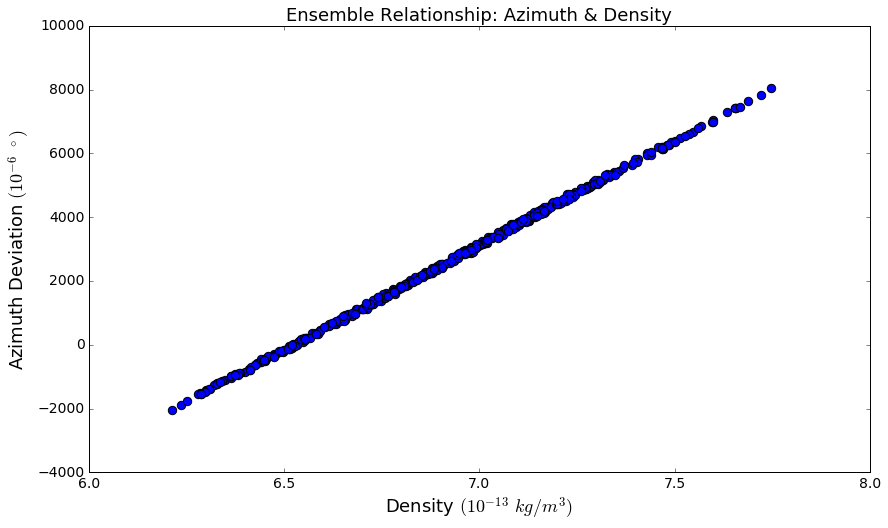

In [23]:
#grab one lat/lon combo & plot the measurement(s) as a function of densities


#density values for ensembles for this lat/lon:
densities = ensembles_of_density_grid[:, plot_lat, plot_lon]

#az measurements for station 1 for ensembles for this lat/lon:
                                        #all ensembles, az, 1st station
az_measurements = ensemble_meas_relationship[:, 2, 0, plot_lat, plot_lon]

print(np.shape(densities), np.shape(az_measurements))

az_measurements_new = np.degrees(az_measurements*1e6)-floor(np.degrees(az_measurements[0]*1e6))


fig = plt.figure()
plt.scatter(densities*1e13, az_measurements_new, s=70, c='b', marker='o')
plt.ylabel(r'Azimuth Deviation $(10^{-6}$ $^\circ)$', fontsize=18)
plt.xlabel(r'Density $(10^{-13}$ $kg/m^3)$', fontsize=18)
plt.title('Ensemble Relationship: Azimuth & Density', fontsize=18)
#legend_names = ['Canberra', 'Madrid', 'Goldstone']
#plt.legend(legend_names, fontsize=16)
#plt.ylim([-y_range,y_range])
#plt.xlim([0,time_hrs[-1]])
plt.show()
fig.savefig('Images/density_az_ensemble.png')
